# Sensor Data Analysis and Plotting
This notebook contains code for loading sensor data, processing it, and generating various plots for analysis.

## Import Required Libraries
The following cell imports the necessary libraries for data manipulation and visualization.

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import os

## Load Datasets
The following cell defines a function to load datasets with proper date parsing and loads the required datasets.

In [22]:
def load_data(file_path):
    df = pd.read_csv(file_path, parse_dates=['receivedAt'])
    df['receivedAt'] = pd.to_datetime(df['receivedAt'])
    df.set_index('receivedAt', inplace=True)
    df.index = df.index.tz_localize(None) if df.index.tz is not None else df.index
    return df

control_daily = load_data('mean_std_data/combined_termoigrometro_PAR_control_daily_mean_std.csv')
shaded_daily = load_data('mean_std_data/combined_termoigrometro_PAR_shaded_daily_mean_std.csv')
control_hourly = load_data('mean_std_data/combined_termoigrometro_PAR_control_hourly_mean_std.csv')
shaded_hourly = load_data('mean_std_data/combined_termoigrometro_PAR_shaded_hourly_mean_std.csv')

## Define Variables to Plot
The following cell defines the variables that will be used for plotting.

In [23]:
variables = ['temperature', 'temperature_daytime', 'temperature_nighttime', 'humidity', 'vaporPressureDeficit', 'photosyntheticallyActiveRadiation']

## Plot Comparison Function
This cell defines a function to plot comparisons between control and shaded data for a given variable and time period.

In [24]:
def plot_comparison(control_df, shaded_df, variable, start_date, end_date, save_path, time_scale='daily'):
    """Plots mean comparison for a given time period and saves it."""

    # Map variable names to y-axis labels
    y_axis_labels = {
        "temperature": "temperature (°C)",
        "temperature_daytime": "temperature_daytime (°C)",
        "temperature_nighttime": "temperature_nighttime (°C)",
        "humidity": "RH (%)",
        "photosyntheticallyActiveRadiation": "PAR (µmol m⁻² s⁻¹)"
    }

    # Filter data for the date range
    mask = (control_df.index >= start_date) & (control_df.index <= end_date)
    control_df = control_df.loc[mask]
    shaded_df = shaded_df.loc[mask]

    if control_df.empty or shaded_df.empty:
        print(f"Skipping {variable} for {start_date} to {end_date} (no data)")
        return

    mean_col = f"{variable}_mean_mean"
    std_col = f"{variable}_mean_std"

    # Skip plotting if required columns are missing
    missing_cols = [
        col for col in [mean_col, std_col]
        if col not in control_df.columns or col not in shaded_df.columns
    ]
    if mean_col not in control_df.columns or mean_col not in shaded_df.columns:
        print(f"Skipping {variable} for {start_date.date()} — missing required column: '{mean_col}'")
        return

    fig, ax = plt.subplots(figsize=(12, 6))

    # Plot mean lines
    ax.plot(control_df.index, control_df[mean_col], label='Control', color='black', linestyle="-", linewidth=1)
    if std_col in control_df.columns:
        ax.fill_between(control_df.index,
                        control_df[mean_col] - 1.96 * control_df[std_col],
                        control_df[mean_col] + 1.96 * control_df[std_col],
                        color='black', alpha=0.2)

    ax.plot(shaded_df.index, shaded_df[mean_col], label='Shaded', color='grey', linestyle="--", linewidth=1)
    if std_col in shaded_df.columns:
        ax.fill_between(shaded_df.index,
                        shaded_df[mean_col] - 1.96 * shaded_df[std_col],
                        shaded_df[mean_col] + 1.96 * shaded_df[std_col],
                        color='grey', alpha=0.2)

    # Optional red threshold lines
    if variable in ['temperature', 'temperature_daytime', 'temperature_nighttime']:
        ax.axhline(y=26, color='red', linestyle='--', linewidth=1, label='Threshold (26°C)')
    elif variable == 'humidity':
        ax.axhline(y=60, color='red', linestyle='--', linewidth=1, label='Threshold (60%)')

    # Title and labels
    title_date_format = '%Y-%m-%d' if time_scale == 'daily' else '%B %Y'
    ax.set_title(f"{variable.capitalize()} Comparison ({start_date.strftime(title_date_format)}"
                 f"{f' to {end_date.strftime(title_date_format)}' if start_date != end_date else ''})")

    # Use personalized y-axis label if available
    y_label = y_axis_labels.get(variable, variable.capitalize())
    ax.set_ylabel(y_label)
    ax.legend()

    end_date = end_date - pd.Timedelta(seconds=1)  # Trim range

    # X-axis formatting
    if time_scale == 'hourly':
        ax.xaxis.set_major_locator(mdates.HourLocator(interval=3))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
        ax.set_xlabel('Time of Day')
    else:
        ax.xaxis.set_major_locator(mdates.DayLocator())
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        ax.set_xlabel('Date')
        ax.set_xlim(start_date, end_date)

    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()

    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    plt.savefig(save_path)
    plt.close()
    print(f"Saved plot: {save_path}")


## Plot Monthly Comparisons
The following cell defines a function to generate monthly comparison plots for all variables.

In [25]:
def plot_monthly_comparison():
    """Plots data for each month using daily data."""
    # Create main folders if they don't exist
    os.makedirs("plots/monthly", exist_ok=True)

    # Get all unique year-month combinations
    unique_months = control_daily.index.to_period('M').unique()

    for month_period in unique_months:
        start_date = month_period.start_time
        end_date = month_period.end_time

        # Create variable folders for this month
        for var in variables:
            variable_folder = f"plots/monthly/{var}"
            os.makedirs(variable_folder, exist_ok=True)

            save_path = f"{variable_folder}/{start_date.strftime('%Y-%m')}.png"

            # Check if the std column exists for the variable
            std_col = f"{var}_mean_std"
            if std_col not in control_daily.columns or std_col not in shaded_daily.columns:
                print(f"Skipping std for {var} as it is missing.")
                plot_comparison(control_daily, shaded_daily, var, start_date, end_date, save_path, time_scale='daily')
            else:
                plot_comparison(control_daily, shaded_daily, var, start_date, end_date, save_path, time_scale='daily')

## Plot Daily Comparisons
This cell defines a function to generate daily comparison plots for all variables.

In [26]:
def plot_daily_comparison():
    """Plots data for each day using hourly data."""
    # Create main folders if they don't exist
    os.makedirs("plots/daily", exist_ok=True)

    # Get all unique dates in the hourly data
    unique_dates = pd.to_datetime(control_hourly.index.date).unique()

    for date in unique_dates:
        start_date = pd.to_datetime(date)
        end_date = start_date + pd.Timedelta(days=1) - pd.Timedelta(seconds=1)

        for var in variables:
            # Skip if the variable is "temperature_daytime" or "temperature_nighttime"
            if var in ["temperature_daytime_mean_mean", "temperature_nighttime_mean_mean"]:
                if var not in control_hourly.columns or var not in shaded_hourly.columns:
                    print(f"Skipping {var} for {start_date.date()} as it is missing in data.")
                    continue

            # Create folder and plot
            variable_folder = f"plots/daily/{var}"
            os.makedirs(variable_folder, exist_ok=True)
            save_path = f"{variable_folder}/{start_date.strftime('%Y-%m-%d')}.png"

            std_col = f"{var}_mean_std"
            if std_col not in control_hourly.columns or std_col not in shaded_hourly.columns:
                print(f"Skipping std for {var} on {start_date.date()} as it is missing.")
                plot_comparison(control_hourly, shaded_hourly, var, start_date, end_date, save_path, time_scale='hourly')
            else:
                plot_comparison(control_hourly, shaded_hourly, var, start_date, end_date, save_path, time_scale='hourly')



## Combined Histogram of t_above_threshold
The following cell defines a function to create a combined chart with separate histograms for temperature sums and counts, each with its own y-axis.

In [27]:
def plot_combined_t_above_threshold(control_file, shaded_file, save_path, time_unit='days'):
    """Creates a combined bar chart with dual y-axes for temperature sums and count > 0 using hatching patterns."""

    # Load data
    control_df = pd.read_csv(control_file)
    shaded_df = pd.read_csv(shaded_file)

    # Calculate values
    control_sum = control_df['t_above_threshold_mean'].sum()
    shaded_sum = shaded_df['t_above_threshold_mean'].sum()

    control_count = (control_df['t_above_threshold_mean'] > 0).sum()
    shaded_count = (shaded_df['t_above_threshold_mean'] > 0).sum()

    # Data
    categories = ['Control', 'Shaded']
    sums = [control_sum, shaded_sum]
    counts = [control_count, shaded_count]

    fig, ax1 = plt.subplots(figsize=(8, 6))

    # Style settings
    bar_width = 0.25  # narrower bars
    x = range(len(categories))
    offset = 0.15     # spacing between bars

    # Bar positions
    sum_positions = [i - offset for i in x]
    count_positions = [i + offset for i in x]

    # Temperature sum bars (left y-axis)
    bars1 = ax1.bar(
        sum_positions,
        sums,
        bar_width,
        color='white',
        edgecolor='black',
        hatch='///',
        label='Temperature Sum (°C)'
    )
    ax1.set_ylabel('Temperature Sum (°C)', color='black')
    ax1.tick_params(axis='y', labelcolor='black')

    # Count bars (right y-axis)
    ax2 = ax1.twinx()
    bars2 = ax2.bar(
        count_positions,
        counts,
        bar_width,
        color='white',
        edgecolor='black',
        label=f'Count ({time_unit})'
    )
    ax2.set_ylabel(f'Count ({time_unit})', color='black')
    ax2.tick_params(axis='y', labelcolor='black')

    # X-axis
    ax1.set_xlabel('Treatment')
    ax1.set_xticks(x)
    ax1.set_xticklabels(categories)

    # Title
    plt.title(f'Temperature Above Threshold: Sum and Count per Treatment ({time_unit.capitalize()})')

    # Adjust vertical space
    max_height = max(sums + counts)
    ax1.set_ylim(0, max_height * 1.6)  # Add 60% headroom

    # Combine legends inside upper-right, avoiding axes and title
    handles1, labels1 = ax1.get_legend_handles_labels()
    handles2, labels2 = ax2.get_legend_handles_labels()
    fig.legend(
        handles1 + handles2,
        labels1 + labels2,
        loc='upper right',
        bbox_to_anchor=(0.9, 0.88),  # Shifted left from edge to avoid y-axis
        frameon=True
    )

    # Save
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Reserve top space
    plt.savefig(save_path)
    plt.close()
    print(f"Saved plot: {save_path}")


## Run Combined Histogram Function
The following cell runs the combined histogram function for t_above_threshold.

In [28]:
plot_combined_t_above_threshold(
    'mean_std_data/combined_termoigrometro_PAR_control_daily_mean_std.csv',
    'mean_std_data/combined_termoigrometro_PAR_shaded_daily_mean_std.csv',
    'plots/combined_t_above_threshold_days.png',
    time_unit='days'
)

plot_combined_t_above_threshold(
    'mean_std_data/combined_termoigrometro_PAR_control_hourly_mean_std.csv',
    'mean_std_data/combined_termoigrometro_PAR_shaded_hourly_mean_std.csv',
    'plots/combined_t_above_threshold_hours.png',
    time_unit='hours'
)

Saved plot: plots/combined_t_above_threshold_days.png
Saved plot: plots/combined_t_above_threshold_hours.png


## DLI Comparison
The following cell defines a function to create histograms comparing DLI (Daily Light Integral) for control and shaded data.

In [29]:
def plot_dli_comparison(control_file, shaded_file, save_path):
    """Creates a histogram comparing DLI (mol m-2 d-1) for control and shaded data."""
    # Load data
    control_df = pd.read_csv(control_file)
    shaded_df = pd.read_csv(shaded_file)

    # Calculate the mean DLI for control and shaded
    control_dli_mean = control_df['DLI_mol m-2 d-1'].sum()
    shaded_dli_mean = shaded_df['DLI_mol m-2 d-1'].sum()

    # Data for the histogram
    categories = ['Control', 'Shaded']
    dli_means = [control_dli_mean, shaded_dli_mean]

    # Plot the histogram
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.bar(categories, dli_means, color=['black', 'white'], alpha=0.7, width=0.5, edgecolor='black', linewidth=1.5)

    # Set labels and title
    ax.set_ylabel('DLI (mol m-2 d-1)')
    ax.set_title('Comparison of DLI (Daily Light Integral)')

    # Save the plot
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    plt.tight_layout()
    plt.savefig(save_path)
    plt.close()
    print(f"Saved DLI comparison histogram: {save_path}")

## Run Plotting Functions
The following cell runs the defined functions to generate and save the plots.

Saved plot: plots/monthly/temperature/2024-06.png
Saved plot: plots/monthly/temperature_daytime/2024-06.png
Saved plot: plots/monthly/temperature_nighttime/2024-06.png
Saved plot: plots/monthly/humidity/2024-06.png
Saved plot: plots/monthly/vaporPressureDeficit/2024-06.png
Skipping std for photosyntheticallyActiveRadiation as it is missing.
Saved plot: plots/monthly/photosyntheticallyActiveRadiation/2024-06.png
Saved plot: plots/monthly/temperature/2024-07.png
Saved plot: plots/monthly/temperature_daytime/2024-07.png
Saved plot: plots/monthly/temperature_nighttime/2024-07.png
Saved plot: plots/monthly/humidity/2024-07.png
Saved plot: plots/monthly/vaporPressureDeficit/2024-07.png
Skipping std for photosyntheticallyActiveRadiation as it is missing.
Saved plot: plots/monthly/photosyntheticallyActiveRadiation/2024-07.png
Saved plot: plots/monthly/temperature/2024-08.png
Saved plot: plots/monthly/temperature_daytime/2024-08.png
Saved plot: plots/monthly/temperature_nighttime/2024-08.png
Sa

KeyboardInterrupt: 

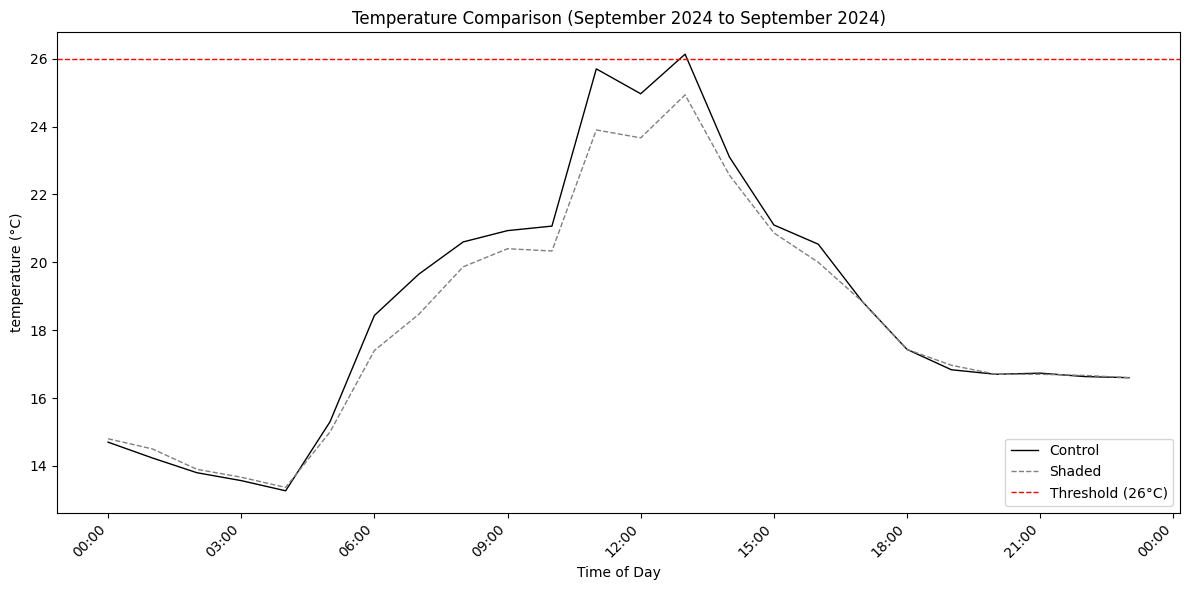

In [30]:

plot_monthly_comparison()


plot_daily_comparison()


plot_dli_comparison(
    'hourly_daily_data/PAR_control_daily.csv',
    'hourly_daily_data/PAR_shaded_daily.csv',
    'plots/dli_comparison_histogram.png'
)
